<h1>Multivariable Linear Regression Data Mining</h1>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from itertools import combinations
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#import,organize data
df = pd.read_csv('main_w_logs.csv')
xfeats = ['1d_return','1d_intraday_return', '1d_afterhours_return','2d_return', '3d_return', '4d_return', '5d_return', '6d_return','7d_return', '8d_return', '9d_return', 
              '10d_return', '15d_return','20d_return', '2h_return', '1h_return', 'spy_1d_return','log_volume']

In [3]:
def multi_regression(indp_vars,mode,state):
    #-----LINEAR MODEL-----#
    #Drop nan values
    df_cleaned = df.dropna(subset=indp_vars)
    df_cleaned = df_cleaned.dropna(subset='return_target')
    #Define x and y vars
    X = df_cleaned[indp_vars]
    y = df_cleaned['return_target']
    #Split into in and out of sample sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=state)
    #Train in-sample model
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    result = model.fit()
    #Predict target returns
    y_pred_train = result.predict(X_train)
    X_test = sm.add_constant(X_test)
    y_pred_test = result.predict(X_test)
    #Rebuild dataframes
    train_df = df_cleaned.loc[X_train.index].copy()
    test_df = df_cleaned.loc[X_test.index].copy()
    #Add predictions
    train_df['y_pred'] = y_pred_train
    test_df['y_pred'] = y_pred_test
    
    if mode == 'output':
        return result.params, result.f_pvalue
    elif mode == 'dataframes':
        return train_df,test_df

<h1>(1): Test all combinations of variables</h1>
<h3>Run all regressions using three different cutoffs as signals. Return following metrics:</h3>
<h3>Average return(in_avg,out_avg)</h3>
<h3>Standard deviation of returns(in_std,out_std)</h3>
<h3>Trades per day(in_trades/day,out_trades/day)</h3>
<h3>Date coverage: percentage of days with at least one trade(in_datecov,out_datecov)</h3>
<h3>Sharpe ratio(in_sharpe,out_sharpe)</h3>
<h3>Product of average returns: rewards consistency and magnitude across samples(avg_product)</h3>

In [4]:
#get all possible independent variable combinations length 2-3
all_combinations = []
for length in range(2, 4):
    # Convert each tuple to a list and extend the combinations list
    all_combinations.extend([list(combo) for combo in itertools.combinations(xfeats, length)])
len(all_combinations)

969

In [ ]:
regression_dataframe = pd.DataFrame()
for feat_combo in tqdm(all_combinations):
    indf, outdf = multi_regression(feat_combo,'dataframes',74)
    ignore, pvalue = multi_regression(feat_combo,'output',74)
    indays = len(indf['date'].unique())
    outdays = len(outdf['date'].unique())
    for tile in (.97,.98,.99):
        cutoff = round(indf['y_pred'].quantile(tile),4)
        #insample data
        intrades = indf[indf['y_pred'] >= cutoff]
        in_avg,in_std = intrades['return_target'].agg(['mean', 'std'])
        in_trades_day = round((len(intrades)/indays),2)
        in_date_cov = round((len(intrades['date'].unique())/indays),2)
        #outsample data
        outtrades = outdf[outdf['y_pred'] >= cutoff]
        out_avg,out_std = outtrades['return_target'].agg(['mean', 'std'])
        out_trades_day = round((len(outtrades)/outdays),2)
        out_date_cov = round((len(outtrades['date'].unique())/outdays),2)
        regression_dataframe = pd.concat([regression_dataframe, pd.DataFrame([{'features': feat_combo, 'in_avg': in_avg, 'in_std': in_std, 'in_trades/day': in_trades_day, 
                                                                       'in_datecov': in_date_cov, 'out_avg': out_avg, 'out_std': out_std, 'out_trades/day': out_trades_day, 
                                                                       'out_datecov': out_date_cov, 'pvalue': round(pvalue, 8)}])], ignore_index=True)
regression_dataframe

In [8]:
#Add sharpe ratio
regression_dataframe['in_sharpe'] = regression_dataframe['in_avg']/regression_dataframe['in_std']
regression_dataframe['out_sharpe'] = regression_dataframe['out_avg']/regression_dataframe['out_std']

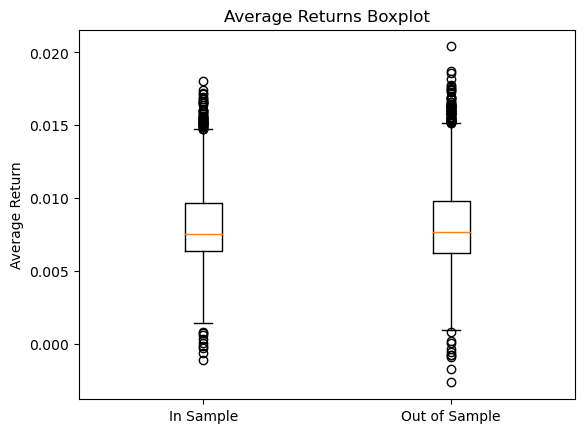

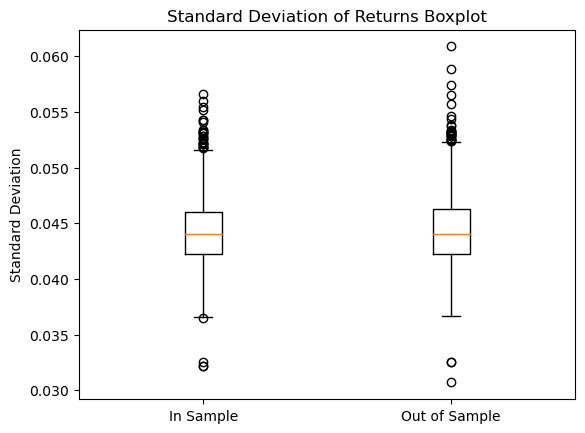

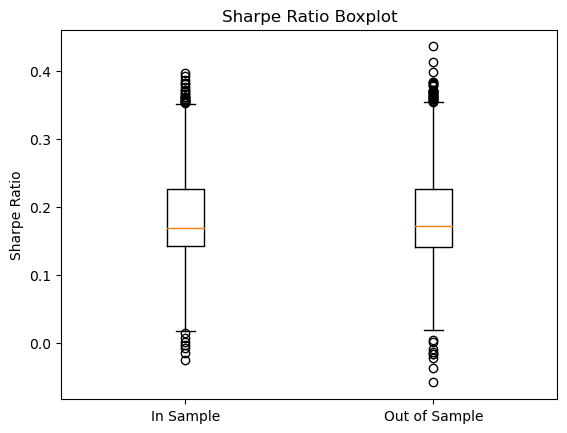

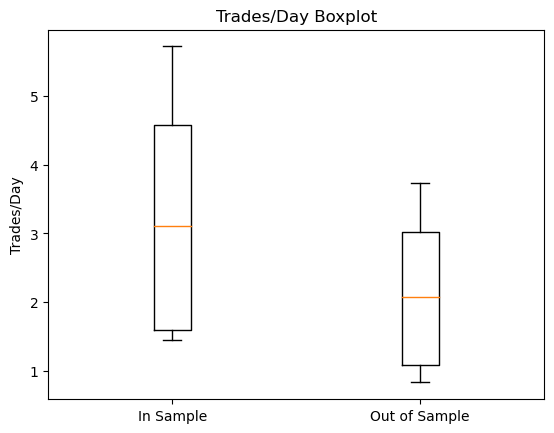

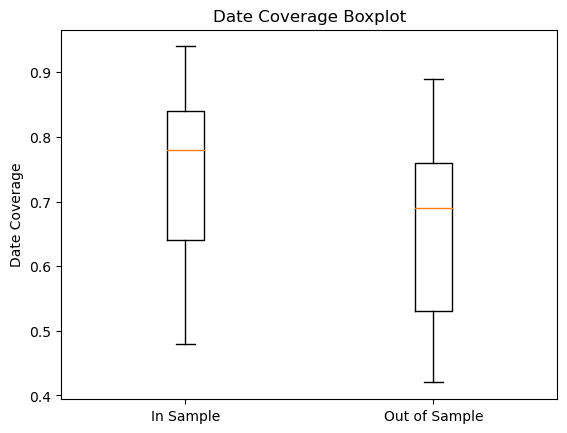

In [10]:
#Boxplots for general regression results and sample comparison
plt.boxplot([regression_dataframe['in_avg'], regression_dataframe['out_avg']], labels=['In Sample', 'Out of Sample'])
plt.title('Average Returns Boxplot')
plt.ylabel('Average Return')
plt.show()

plt.boxplot([regression_dataframe['in_std'], regression_dataframe['out_std']], labels=['In Sample', 'Out of Sample'])
plt.title('Standard Deviation of Returns Boxplot')
plt.ylabel('Standard Deviation')
plt.show()

plt.boxplot([regression_dataframe['in_sharpe'], regression_dataframe['out_sharpe']], labels=['In Sample', 'Out of Sample'])
plt.title('Sharpe Ratio Boxplot')
plt.ylabel('Sharpe Ratio')
plt.show()

plt.boxplot([regression_dataframe['in_trades/day'], regression_dataframe['out_trades/day']], labels=['In Sample', 'Out of Sample'])
plt.title('Trades/Day Boxplot')
plt.ylabel('Trades/Day')
plt.show()

plt.boxplot([regression_dataframe['in_datecov'], regression_dataframe['out_datecov']], labels=['In Sample', 'Out of Sample'])
plt.title('Date Coverage Boxplot')
plt.ylabel('Date Coverage')
plt.show()

In [11]:
#F P-Value descriptions
regression_dataframe['pvalue'].describe()

count    2.907000e+03
mean     2.775955e-07
std      8.638230e-06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.689900e-04
Name: pvalue, dtype: float64

In [12]:
avg_results = {xfeat: {'In Sample Average Return':regression_dataframe[regression_dataframe['features'].apply(lambda feats: xfeat in feats)]['in_avg'].mean(),
                       'Out of Sample Average Return':regression_dataframe[regression_dataframe['features'].apply(lambda feats: xfeat in feats)]['out_avg'].mean(),
                       'Average Product': regression_dataframe[regression_dataframe['features'].apply(lambda feats: xfeat in feats)]['in_avg'].mean() *
                        regression_dataframe[regression_dataframe['features'].apply(lambda feats: xfeat in feats)]['out_avg'].mean()}
    for xfeat in xfeats}
pd.DataFrame(avg_results).T.sort_values(by='Average Product',ascending=False)

,In Sample Average Return,Out of Sample Average Return,Average Product
2h_return,0.011201,0.011467,0.000128
1h_return,0.011253,0.011249,0.000127
1d_return,0.008479,0.008536,0.000072
1d_intraday_return,0.008216,0.008205,0.000067
2d_return,0.008200,0.008127,0.000067
10d_return,0.008079,0.008132,0.000066
3d_return,0.007899,0.008097,0.000064
log_volume,0.007900,0.008041,0.000064
6d_return,0.007898,0.007953,0.000063
8d_return,0.007885,0.007791,0.000061


In [13]:
sharpe_results = {xfeat: {'In Sample Sharpe Ratio':regression_dataframe[regression_dataframe['features'].apply(lambda feats: xfeat in feats)]['in_sharpe'].mean(),
                       'Out of Sample Sharpe Ratio':regression_dataframe[regression_dataframe['features'].apply(lambda feats: xfeat in feats)]['out_sharpe'].mean(),
                       'Sharpe Ratio Product': regression_dataframe[regression_dataframe['features'].apply(lambda feats: xfeat in feats)]['in_sharpe'].mean() *
                        regression_dataframe[regression_dataframe['features'].apply(lambda feats: xfeat in feats)]['out_sharpe'].mean()}
    for xfeat in xfeats}
pd.DataFrame(sharpe_results).T.sort_values(by='Sharpe Ratio Product',ascending=False)

,In Sample Sharpe Ratio,Out of Sample Sharpe Ratio,Sharpe Ratio Product
1h_return,0.271433,0.268323,0.072832
2h_return,0.257427,0.260427,0.067041
10d_return,0.186496,0.187189,0.034910
1d_return,0.186018,0.186557,0.034703
1d_intraday_return,0.185511,0.186523,0.034602
15d_return,0.183379,0.179774,0.032967
log_volume,0.179786,0.182297,0.032774
2d_return,0.181847,0.180144,0.032759
6d_return,0.177869,0.179472,0.031922
3d_return,0.175782,0.180622,0.031750


In [14]:
dcov_results = {xfeat: {'In Sample Date Coverage':regression_dataframe[regression_dataframe['features'].apply(lambda feats: xfeat in feats)]['in_datecov'].mean(),
                       'Out of Sample Date Coverage':regression_dataframe[regression_dataframe['features'].apply(lambda feats: xfeat in feats)]['out_datecov'].mean()}
for xfeat in xfeats}
pd.DataFrame(dcov_results).T

,In Sample Date Coverage,Out of Sample Date Coverage
1d_return,0.773704,0.677386
1d_intraday_return,0.746623,0.655795
1d_afterhours_return,0.770261,0.672810
2d_return,0.758824,0.665795
3d_return,0.755556,0.662222
4d_return,0.755098,0.657778
5d_return,0.750545,0.660675
6d_return,0.752810,0.658431
7d_return,0.750174,0.656514
8d_return,0.750153,0.653333


<h1>Iteration Conclusions</h1>
<h3>a: average return, standard deviation of returns and sharpe ratio are relatively unaffected across samples</h3>
<h3>b: trades/day and date coverage decrease greatly from in sample to out of sample</h3>
<h3>c: all f-statistic p-values indicate statistical significance</h3>
<h3>d: 2h_return, 1h_return are best at maximizing return and risk-adjusted return</h3>

<h1>(2): Determine ideal combination of return and frequency using geometric gain expectancy and date coverage</h1>
<h3>Expected annual return = (1+gge)^days -1 </h3>
<h3>Determine train and test sets with various different random states, take average to smooth and improve prediction</h3>
<h3>Using 1h_return and 2h_return as regression features</h3>
<h3>Note: expected annual return statistic is not accurate for projection, will deplete due to slippage</h3>

Running Regression: 100%|██████████| 500/500 [02:48<00:00,  2.97it/s]


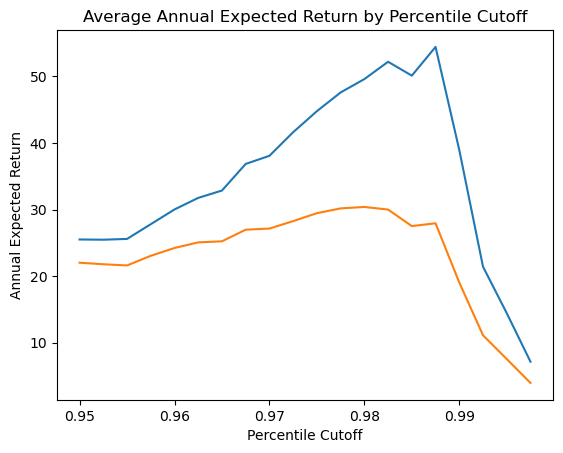

In [37]:
#determine ideal trades/day and date coverage using 1h/2h return regression
annual_exp_dict = {}
for state in tqdm(np.random.randint(0, 1000, size=500), desc="Running Regression"):
    dfin,dfout = multi_regression(['1h_return','2h_return'],'dataframes',state)

    cutoffs = []
    for tile in [round(tile, 4) for tile in np.arange(0.95, 0.9975, 0.0025)]:
        cutoffs.append(round(dfin['y_pred'].quantile(tile),4))

    for dataframe,sample in zip([dfin,dfout],['in','out']):
        for cutoff,tile in zip(cutoffs,[round(tile, 4) for tile in np.arange(0.95, 0.9975, 0.0025)]):
            filt_df = dataframe[dataframe['y_pred'] >= cutoff]
            trade_days = len(filt_df['date'].unique())
            win_avg_return,num_win = filt_df[filt_df['return_target'] > 0]['return_target'].agg(['mean','count'])
            loss_avg_return,num_loss = filt_df[filt_df['return_target'] < 0]['return_target'].agg(['mean','count'])
            win_pct = num_win/len(filt_df)
            loss_pct = num_loss/len(filt_df)
            gge = (1+win_avg_return)** win_pct * (1-abs(loss_avg_return)) ** loss_pct -1
            exp_annual_return = (1+gge)** trade_days -1
            if f'{tile}{sample}' not in annual_exp_dict:
                annual_exp_dict[f'{tile}{sample}'] = []
            annual_exp_dict[f'{tile}{sample}'].append(exp_annual_return)

in_y = []
for inkey in list(annual_exp_dict.keys())[:20]:
    in_y.append(np.mean(annual_exp_dict.get(inkey, [])))
plt.plot([round(tile, 4) for tile in np.arange(0.95, 0.9975, 0.0025)],in_y)

out_y = []
for outkey in list(annual_exp_dict.keys())[20:]:
    out_y.append(np.mean(annual_exp_dict.get(outkey, [])))
plt.plot([round(tile, 4) for tile in np.arange(0.95, 0.9975, 0.0025)],out_y)
plt.title('Average Annual Expected Return by Percentile Cutoff')
plt.xlabel('Percentile Cutoff')
plt.ylabel('Annual Expected Return')
plt.show()

<h1>(3): Test variable combinations all including 2h_return or 1h_return</h1>
<h3>Select percentile cutoff 0.9825</h3>
<h3>Pick best combinations based on annual expected return using geometric gain expectancy and annualized standard deviation</h3>
<h3>Also test 1h_return and 2h_return alone</h3>

In [38]:
#generate combinations
combinations_12h = [list(combo) for length in range(2, 5)for combo in itertools.combinations(xfeats, length)if '1h_return' in combo or '2h_return' in combo]
combinations_12h.append('1h_return')
combinations_12h.append('2h_return')
len(combinations_12h)

1531

In [45]:
regression_dataframe = pd.DataFrame()
for feat_combo in tqdm(combinations_12h):
    indf, outdf = multi_regression(feat_combo,'dataframes',70)
    indays = len(indf['date'].unique())
    outdays = len(outdf['date'].unique())
    cutoff = round(indf['y_pred'].quantile(.9825),4)
    #insample data
    intrades = indf[indf['y_pred'] >= cutoff]
    in_avg,in_std = intrades['return_target'].agg(['mean', 'std'])
    in_dates = (len(intrades['date'].unique()))
    in_wavg,in_nwin = intrades[intrades['return_target'] > 0]['return_target'].agg(['mean','count'])
    in_lavg,in_nloss = intrades[intrades['return_target'] < 0]['return_target'].agg(['mean','count'])
    in_pwin = in_nwin/len(intrades)
    in_ploss = in_nloss/len(intrades)
    in_gge = (1+in_wavg)** in_pwin * (1-abs(in_lavg)) ** in_ploss -1
    in_exp_annual = (1+in_gge)** in_dates -1
    in_std_annual = in_std*(np.sqrt(in_dates))
    #outsample data
    outrades = outdf[outdf['y_pred'] >= cutoff]
    out_avg, out_std = outrades['return_target'].agg(['mean', 'std'])
    out_dates = len(outrades['date'].unique())
    out_wavg, out_nwin = outrades[outrades['return_target'] > 0]['return_target'].agg(['mean', 'count'])
    out_lavg, out_nloss = outrades[outrades['return_target']< 0]['return_target'].agg(['mean', 'count'])
    out_pwin = out_nwin/len(outrades)
    out_ploss = out_nloss /len(outrades)
    out_gge = (1 + out_wavg) ** out_pwin * (1 - abs(out_lavg)) ** out_ploss - 1
    out_exp_annual = (1 + out_gge)** out_dates - 1
    out_std_annual = out_std*(np.sqrt(out_dates))
    regression_dataframe = pd.concat([regression_dataframe, pd.DataFrame([{'features': feat_combo, 'in_avg': in_avg,'in_exp_annual':in_exp_annual, 
                                                                            'in_std_annual':in_std_annual,'out_avg':out_avg,'out_exp_annual':out_exp_annual,
                                                                            'out_std_annual':out_std_annual}])], ignore_index=True)
regression_dataframe

100%|██████████| 1531/1531 [05:32<00:00,  4.61it/s]


,features,in_avg,in_exp_annual,in_std_annual,out_avg,out_exp_annual,out_std_annual
0,"[1d_return, 2h_return]",0.011153,64.392255,0.928559,0.012833,58.087153,0.929568
1,"[1d_return, 1h_return]",0.010671,53.905939,0.873202,0.010838,34.122186,0.818408
2,"[1d_intraday_return, 2h_return]",0.009837,35.640709,0.880420,0.013475,99.079348,0.806146
3,"[1d_intraday_return, 1h_return]",0.011040,59.873097,0.836005,0.009705,26.859464,0.793714
4,"[1d_afterhours_return, 2h_return]",0.012270,90.663862,0.922847,0.007741,10.148197,0.901904
...,...,...,...,...,...,...,...
1526,"[20d_return, 2h_return, spy_1d_return, log_vol...",0.013208,96.831373,0.815872,0.013524,62.663820,0.730879
1527,"[20d_return, 1h_return, spy_1d_return, log_vol...",0.012658,92.500137,0.784598,0.011304,31.439930,0.714378
1528,"[2h_return, 1h_return, spy_1d_return, log_volume]",0.009868,38.567925,0.828572,0.012439,55.798183,0.779340
1529,1h_return,0.011142,60.612663,0.845061,0.011063,32.976537,0.862748


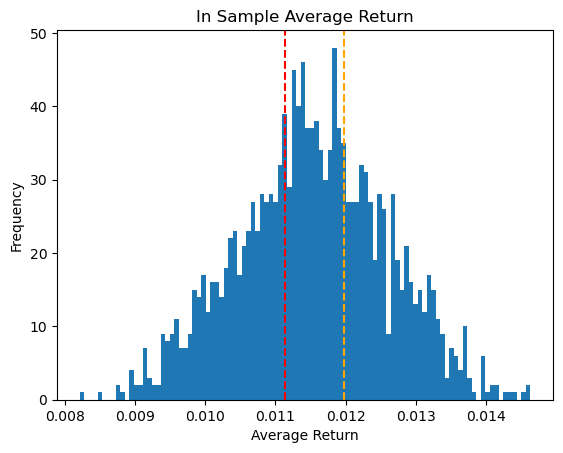

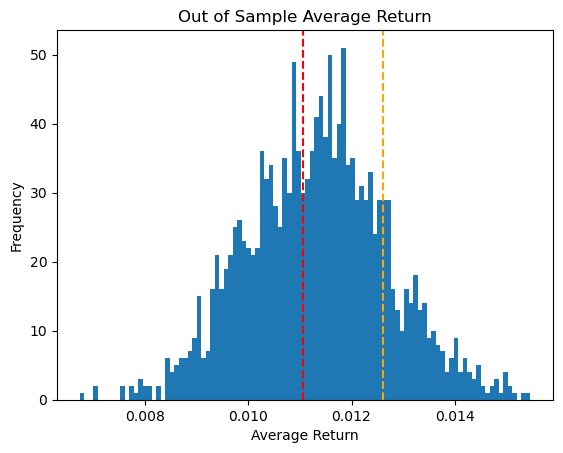

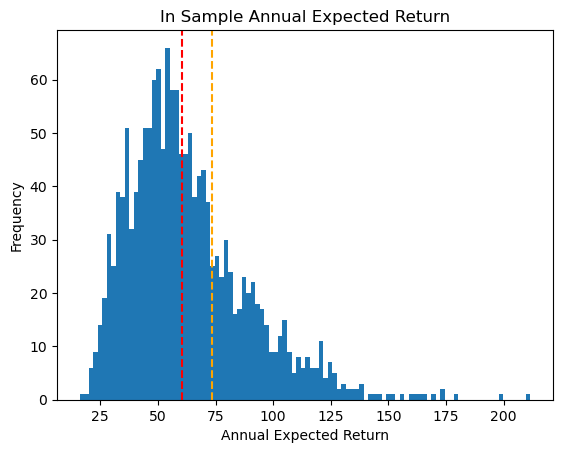

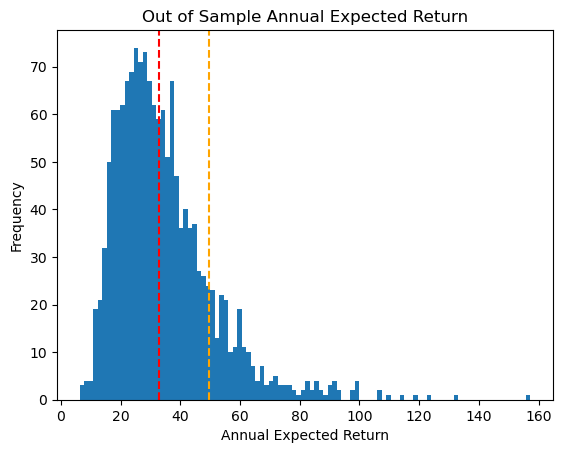

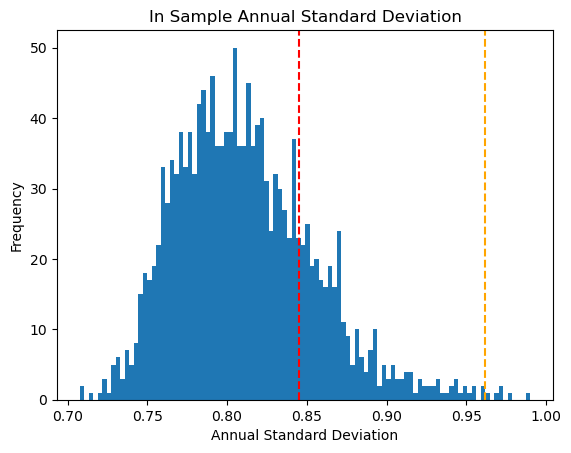

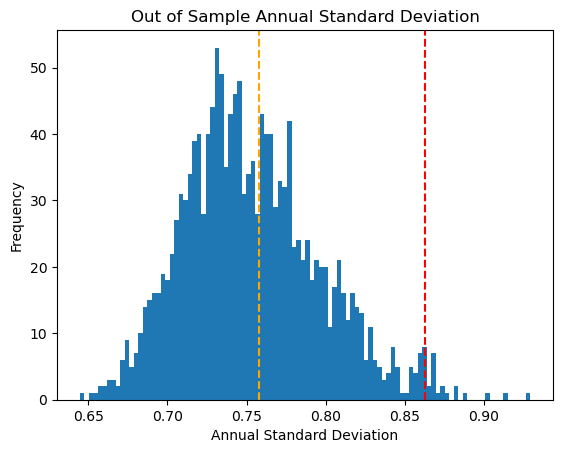

In [47]:
#Histograms to describe average return, annual expected return, annual standard deviation
#Also plot performance of singular 1h/2h variables
plt.hist(regression_dataframe['in_avg'],bins=100)
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '2h_return', 'in_avg'].values[0],color='orange', linestyle='--', label='2h_return')
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '1h_return', 'in_avg'].values[0],color='red', linestyle='--', label='1h_return')
plt.title('In Sample Average Return')
plt.xlabel('Average Return')
plt.ylabel('Frequency')
plt.show()

plt.hist(regression_dataframe['out_avg'],bins=100)
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '2h_return', 'out_avg'].values[0],color='orange', linestyle='--', label='2h_return')
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '1h_return', 'out_avg'].values[0],color='red', linestyle='--', label='1h_return')
plt.title('Out of Sample Average Return')
plt.xlabel('Average Return')
plt.ylabel('Frequency')
plt.show()

plt.hist(regression_dataframe['in_exp_annual'],bins=100)
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '2h_return', 'in_exp_annual'].values[0],color='orange', linestyle='--', label='2h_return')
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '1h_return', 'in_exp_annual'].values[0],color='red', linestyle='--', label='1h_return')
plt.title('In Sample Annual Expected Return')
plt.xlabel('Annual Expected Return')
plt.ylabel('Frequency')
plt.show()

plt.hist(regression_dataframe['out_exp_annual'],bins=100)
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '2h_return', 'out_exp_annual'].values[0],color='orange', linestyle='--', label='2h_return')
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '1h_return', 'out_exp_annual'].values[0],color='red', linestyle='--', label='1h_return')
plt.title('Out of Sample Annual Expected Return')
plt.xlabel('Annual Expected Return')
plt.ylabel('Frequency')
plt.show()

plt.hist(regression_dataframe['in_std_annual'],bins=100)
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '2h_return', 'in_std_annual'].values[0],color='orange', linestyle='--', label='2h_return')
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '1h_return', 'in_std_annual'].values[0],color='red', linestyle='--', label='1h_return')
plt.title('In Sample Annual Standard Deviation')
plt.xlabel('Annual Standard Deviation')
plt.ylabel('Frequency')
plt.show()

plt.hist(regression_dataframe['out_std_annual'],bins=100)
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '2h_return', 'out_std_annual'].values[0],color='orange', linestyle='--', label='2h_return')
plt.axvline(regression_dataframe.loc[regression_dataframe['features'] == '1h_return', 'out_std_annual'].values[0],color='red', linestyle='--', label='1h_return')
plt.title('Out of Sample Annual Standard Deviation')
plt.xlabel('Annual Standard Deviation')
plt.ylabel('Frequency')
plt.show()

In [76]:
#Filter to only top 50 performers based on product of in and out of sample annual expected return, get number of time variable appears
regression_dataframe['exp_annual_product'] = regression_dataframe['in_exp_annual'] * regression_dataframe['out_exp_annual']
reg_filt = regression_dataframe.sort_values(by='exp_annual_product', ascending=False).head(100)
print(reg_filt['features'].apply(lambda feats: [feat for feat in xfeats if feat in feats]).explode().value_counts())
print()
print('Number of times 1h_return and 2h_return used in same regression:')
print(reg_filt[reg_filt['features'].apply(lambda feats: '1h_return' in feats and '2h_return' in feats)].shape[0])

2h_return               64
10d_return              51
log_volume              51
1h_return               38
spy_1d_return           35
15d_return              25
1d_return               22
20d_return              20
1d_afterhours_return    19
9d_return               16
6d_return               11
8d_return                9
1d_intraday_return       8
5d_return                8
3d_return                3
2d_return                2
7d_return                1
4d_return                1
Name: features, dtype: int64

Number of times 1h_return and 2h_return used in same regression:
2


In [77]:
#Top 10
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None) # Show full column width
pd.set_option('display.max_rows', None) 

regression_dataframe.sort_values(by='exp_annual_product', ascending=False).head(10)

,features,in_avg,in_exp_annual,in_std_annual,out_avg,out_exp_annual,out_std_annual,exp_annual_product
868,"[1d_afterhours_return, 15d_return, 1h_return, spy_1d_return]",0.012540,102.332978,0.817748,0.014172,99.038615,0.735424,10134.916409
1513,"[10d_return, 2h_return, spy_1d_return, log_volume]",0.013315,106.694035,0.845647,0.014723,92.968982,0.710096,9919.235804
287,"[2h_return, spy_1d_return, log_volume]",0.011821,81.208574,0.929101,0.014484,119.204977,0.787242,9680.466187
862,"[1d_afterhours_return, 10d_return, 1h_return, log_volume]",0.013966,165.552278,0.824744,0.012715,53.151129,0.755465,8799.290540
1472,"[8d_return, 2h_return, spy_1d_return, log_volume]",0.012348,79.774865,0.826773,0.015329,106.761602,0.786552,8516.892454
703,"[1d_intraday_return, 20d_return, 2h_return, log_volume]",0.014146,173.023015,0.809058,0.012287,44.820231,0.710014,7754.931514
1517,"[15d_return, 20d_return, 2h_return, log_volume]",0.014016,138.655964,0.782905,0.012808,53.666171,0.740981,7441.134643
1497,"[9d_return, 2h_return, spy_1d_return, log_volume]",0.012969,115.474674,0.829502,0.013946,64.422741,0.786324,7439.194983
1514,"[10d_return, 1h_return, spy_1d_return, log_volume]",0.012586,87.845334,0.784890,0.014067,83.899798,0.689545,7370.205738
1377,"[6d_return, 15d_return, 2h_return, log_volume]",0.013410,85.093395,0.775909,0.014850,84.905868,0.701554,7224.928581


<h1>Iteration Conclusions</h1>
<h3>a: using both 1h_return and 2h_return not neccesary</h3>
<h3>b: best feature combination is [1d_afterhours_return, 15d_return, 1h_return, spy_1d_return]</h3>
<h3>move to more robust testing for [1d_afterhours_return, 15d_return, 1h_return, spy_1d_return] (and for others if neccessary)</h3>